Second approach getting all datapoints

In [1]:
#%matplotlib
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
con = sqlite3.connect('home-assistant_v2.db')

In [2]:
cur = con.cursor()

data = [{"temperature": [pd.NA], "humidity": [pd.NA], "time":[pd.NaT], "hum_out":[pd.NA],"temp_out":[pd.NA], "humidity_oben": [pd.NA], "temperature_oben":[pd.NA]}]

for row in cur.execute('SELECT state, last_updated_ts, entity_id FROM states WHERE entity_id IN ("sensor.badezimmer_temperatur", "sensor.badezimmer_luftfeuchtigkeit", "sensor.badezimmer_oben_temperatur", "sensor.badezimmer_oben_luftfeuchtigkeit", "sensor.wupws_temp", "sensor.wupws_humidity") ORDER BY last_updated_ts;'):
    new_data = data[-1].copy()
    new_data["time"] = [row[1]]
    if row[-1].split("_")[1] == "temperatur":
        new_data["temperature"] = [row[0]]
    elif row[-1].split("_")[1] == "luftfeuchtigkeit":
        new_data["humidity"] = [row[0]]
    elif row[-1].split("_")[1] == "temp":
        new_data["temp_out"] = [row[0]]
    elif row[-1].split("_")[1] == "humidity":
        new_data["hum_out"] = [row[0]]
    elif row[-1] == "sensor.badezimmer_oben_temperatur":
        new_data["temperature_oben"] = [row[0]]
    elif row[-1] == "sensor.badezimmer_oben_luftfeuchtigkeit":
        new_data["humidity_oben"] = [row[0]]
    else:
        print(row)
    data.append(new_data)
    data[-2] = pd.DataFrame(data[-2])
data[-1] = pd.DataFrame(data[-1])
#con.close()

In [61]:
data["time"] = pd.to_datetime(data["time"], unit='s')

In [4]:
data.to_csv("data-test.csv")

In [3]:
data = pd.concat(data, ignore_index=True)

In [5]:
con.close()

In [4]:
data[data["humidity"]>65]#.plot.scatter(x="time", y="humidity", figsize=(120,40))

TypeError: '>' not supported between instances of 'str' and 'int'

In [2]:
data = pd.read_csv("data_bll_v2.csv", sep=";")
data["humidity"] = pd.to_numeric(data["humidity"], errors='coerce')
data["temperature"] = pd.to_numeric(data["temperature"], errors='coerce')
data["time"] = pd.to_datetime(data["time"], format="%Y-%m-%d %H:%M:%S")
data

,Unnamed: 0,temperature,humidity,time
0,1,15.7,NaN,2022-05-02 02:15:06.958630
1,2,15.6,NaN,2022-05-02 02:16:14.762999
2,3,15.5,NaN,2022-05-02 02:29:47.205489
3,4,20.0,NaN,2022-05-02 02:33:43.650160
4,5,15.4,NaN,2022-05-02 02:34:24.430729
...,...,...,...,...
8921,8922,24.2,56.0,2022-05-12 07:06:18.862979
8922,8923,24.2,55.0,2022-05-12 07:07:11.028293
8923,8924,24.2,56.0,2022-05-12 07:08:56.662981
8924,8925,24.2,55.0,2022-05-12 07:11:31.391785


In [3]:
plt.plot(data["time"], data["humidity"])
plt.ylabel('relative Luftfeuchtigkeit')
plt.xlabel('Zeit')
plt.show()

In [3]:
import datetime
to_process = pd.read_csv("data.../duschen.csv")
shower_max=0
# for shower
showering = []

current_ID = shower_max +1

for i in range(len(to_process)):
    year, month = 2022, 5#to_process["Monat"][i]
    day_start, day_end = to_process["Tag"][i], to_process["Tag"][i]
    if to_process["Beginn"][i] > to_process["Ende"][i]:
        time_end = to_process["Stunde"][i]+1
    else:
        time_end = to_process["Stunde"][i]
    start = datetime.datetime(year, month, day_start, to_process["Stunde"][i], to_process["Beginn"][i])
    end = datetime.datetime(year, month, day_end, time_end, to_process["Ende"][i])
    time_mask = (data['time'] >= start) & \
            (data['time'] <= end)
    showering.append(data[time_mask].copy())
    showering[-1]["Id"] = current_ID
    current_ID += 1

showering = pd.concat(showering, ignore_index=True)

In [4]:
dush = showering
id = -1
local_time = []
for i in range(len(dush)):  
    if dush.iloc[i]["Id"] != id:
        id = dush.iloc[i]["Id"]
        first_time = dush.iloc[i]["time"]
        time = 0
    else:
        time = (dush.iloc[i]["time"] - first_time).seconds//60
        
    local_time.append(time)
dush["local time"] = local_time
dush["room"] = "middle"

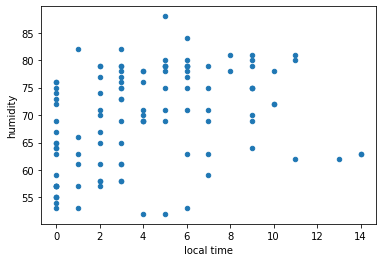

In [8]:
dush.plot.scatter(x="local time", y="humidity")
dush.to_csv("shower.csv", sep=";")

In [9]:
dush = pd.read_csv("shower.csv", sep=";")
import numpy as np

def relative_to_absolute(humidity, temperature):  # Source https://journals.ametsoc.org/view/journals/bams/86/2/bams-86-2-225.xml?tab_body=pdf Equation 10 p.226
    T = temperature + 273.15 # Converting Celsius to Kelvin
    Rw = 461.5 # JK^(-1)kg^(-1)
    C2 = 2.53 * 10**8 #kPa
    L =  2.501 * 10**6 #J kg^(-1)
    return (humidity/100)*(C2*np.exp((-L/Rw)/T))

absolute = []
for index, row in dush.iterrows():
    if isinstance(row["temperature"], float) and isinstance(row["humidity"],float):
        absolute.append(relative_to_absolute(row["humidity"], row["temperature"]))
    else:
        absolute.append("NaN")

dush["absolute"] = absolute

<AxesSubplot:xlabel='local time', ylabel='absolute'>

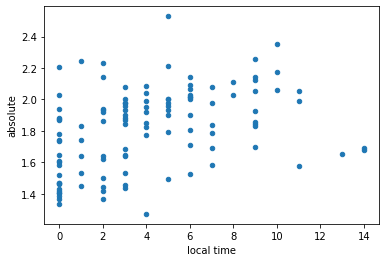

In [11]:
dush.plot.scatter(x="local time", y="absolute")

<AxesSubplot:xlabel='local time', ylabel='temperature'>

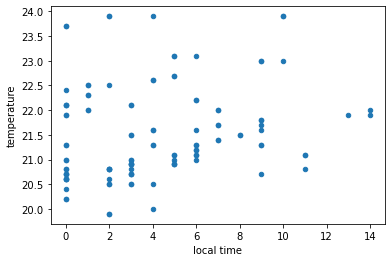

In [12]:
dush.plot.scatter(x="local time", y="temperature")